In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('LD2011_2014.txt', sep=';',  parse_dates=True)

C:\Users\91740\AppData\Local\Temp\ipykernel_17388\397116715.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,157,160,164,165,167,170,173,177,178,179,181,184,185,186,223,224,255,280,289,305,308,322,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,363,364,365,366,367,368,369,370) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('LD2011_2014.txt', sep=';',  parse_dates=True)


In [3]:
df.head()

Unnamed: 0 MT_001 MT_002 MT_003 MT_004 MT_005 MT_006 MT_007  \
0  2011-01-01 00:15:00      0      0      0      0      0      0      0   
1  2011-01-01 00:30:00      0      0      0      0      0      0      0   
2  2011-01-01 00:45:00      0      0      0      0      0      0      0   
3  2011-01-01 01:00:00      0      0      0      0      0      0      0   
4  2011-01-01 01:15:00      0      0      0      0      0      0      0   

  MT_008 MT_009  ... MT_361 MT_362 MT_363 MT_364 MT_365 MT_366 MT_367 MT_368  \
0      0      0  ...      0    0.0      0      0      0      0      0      0   
1      0      0  ...      0    0.0      0      0      0      0      0      0   
2      0      0  ...      0    0.0      0      0      0      0      0      0   
3      0      0  ...      0    0.0      0      0      0      0      0      0   
4      0      0  ...      0    0.0      0      0      0      0      0      0   

  MT_369 MT_370  
0      0      0  
1      0      0  
2      0      0  
3      0      0  
4      0      0  

[5 rows x 371 columns]

In [4]:
df.shape

(140256, 371)

In [8]:
df.isna().sum()

Unnamed: 0    0
MT_001        0
MT_002        0
MT_003        0
MT_004        0
             ..
MT_366        0
MT_367        0
MT_368        0
MT_369        0
MT_370        0
Length: 371, dtype: int64

In [9]:
dup = df.duplicated()
print(dup)

0         False
1         False
2         False
3         False
4         False
          ...  
140251    False
140252    False
140253    False
140254    False
140255    False
Length: 140256, dtype: bool


In [10]:
data_types = df.dtypes
print(data_types)

Unnamed: 0    object
MT_001        object
MT_002        object
MT_003        object
MT_004        object
               ...  
MT_366        object
MT_367        object
MT_368        object
MT_369        object
MT_370        object
Length: 371, dtype: object


In [11]:
df.iloc[:, 1:] = df.iloc[:, 1:].replace({',': '.'}, regex=True)

In [12]:
df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)

In [13]:
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])

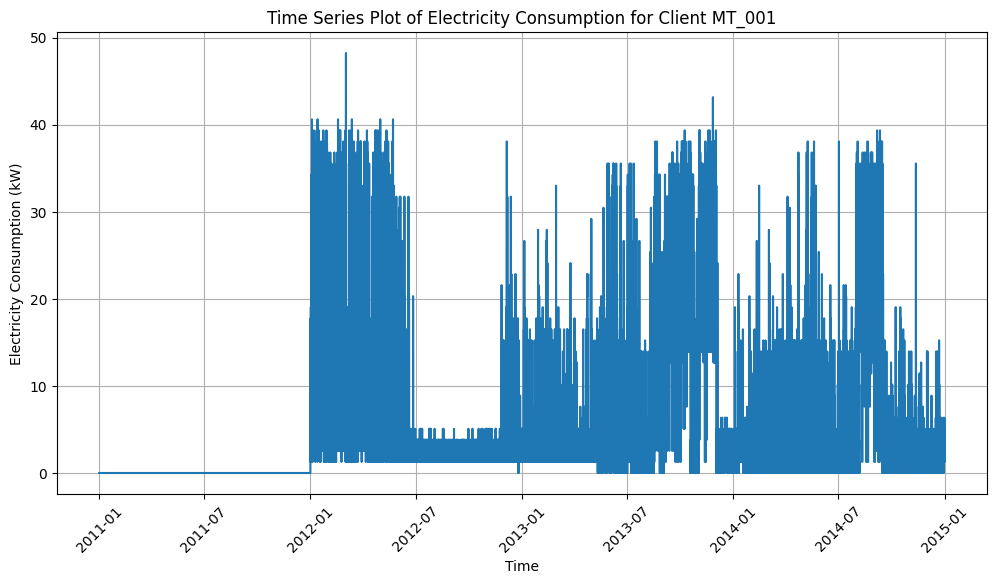

In [14]:
client_id = 'MT_001' 
plt.figure(figsize=(12, 6))
sns.lineplot(x='Unnamed: 0', y=client_id, data=df)
plt.title('Time Series Plot of Electricity Consumption for Client {}'.format(client_id))
plt.xlabel('Time')
plt.ylabel('Electricity Consumption (kW)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [15]:
clients_subset = df.iloc[:, 1:20]  

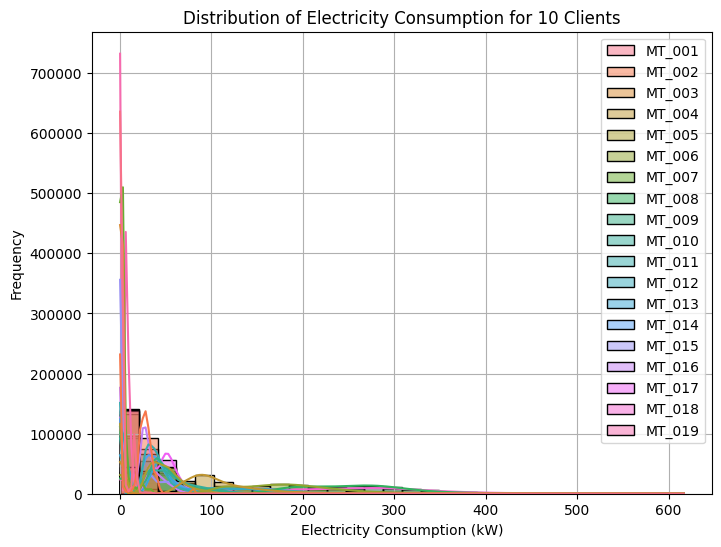

In [16]:
plt.figure(figsize=(8, 6))
sns.histplot(data=clients_subset, bins=30, kde=True)
plt.title('Distribution of Electricity Consumption for 10 Clients')
plt.xlabel('Electricity Consumption (kW)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



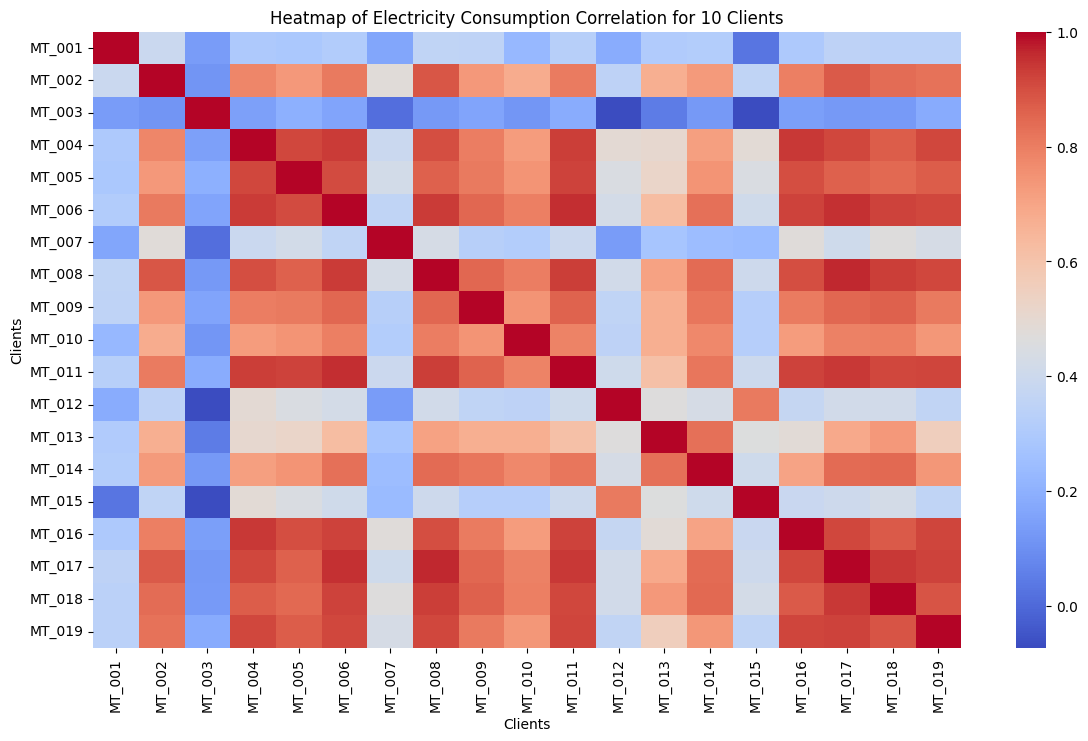

In [17]:
plt.figure(figsize=(14, 8))
sns.heatmap(clients_subset.corr(), cmap='coolwarm', annot=False)
plt.title('Heatmap of Electricity Consumption Correlation for 10 Clients')
plt.xlabel('Clients')
plt.ylabel('Clients')
plt.show()

In [18]:
numerical_columns = df.select_dtypes(include=['number']).columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[numerical_columns])
scaled_df = pd.DataFrame(scaled_data, columns=numerical_columns)

In [19]:
data_length = len(scaled_df)

In [145]:
train_percent = 0.7
val_percent = 0.1
test_percent = 0.2


In [146]:
train_size = int(data_length * train_percent)
val_size = int(data_length * val_percent)
test_size = data_length - train_size - val_size

In [147]:
train_data = scaled_df[:train_size]
val_data = scaled_df[train_size:train_size + val_size]
test_data = scaled_df[train_size + val_size:]

print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

Train set size: 98179
Validation set size: 14025
Test set size: 28052


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import time

In [126]:
print(train_data.index)

RangeIndex(start=0, stop=98179, step=1)


In [173]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, sequence_length):
        # Print the size and shape of the input data before reshaping
        print("Before reshaping:")
        print("Data size:", len(data))
        print("Data shape:", data.shape)

        # Reshape data to have sequence length of 32 and input size of 370
        self.data = torch.tensor(data).view(-1, sequence_length, 370).float()

        # Print the size and shape of the input data after reshaping
        print("\nAfter reshaping:")
        print("Data size:", len(self.data))
        print("Data shape:", self.data.shape)

        # Reshape targets to have output size of 370
        self.targets = torch.tensor(targets).view(-1, 370).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

def create_dataloader(generator, batch_size):
    X_batches, y_batches = [], []
    for i in range(len(generator)):
        X, y = generator[i]
        X_batches.append(X)
        y_batches.append(y)
    X_data = torch.tensor(np.concatenate(X_batches), dtype=torch.float32)
    y_data = torch.tensor(np.concatenate(y_batches), dtype=torch.float32)
    dataset = TensorDataset(X_data, y_data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [170]:
n_input = 32
train_generator = TimeseriesGenerator(train_data.values, train_data.values, length=n_input, batch_size=16)
val_generator = TimeseriesGenerator(val_data.values, val_data.values, length=n_input, batch_size=16)
test_generator = TimeseriesGenerator(test_data.values, test_data.values, length=n_input, batch_size=16)

In [171]:
X, y = train_generator[0]
print("Input shape:", X.shape) 
print("Output shape:", y.shape)

Input shape: (16, 32, 1)
Output shape: (16, 1)


In [174]:
train_loader = create_dataloader(train_generator, batch_size=16)
val_loader = create_dataloader(val_generator, batch_size=16)
test_loader = create_dataloader(test_generator, batch_size=64)


In [176]:
X, y = train_generator[0]
print(X.shape)
print(X.flatten())
print(y)  


(16, 32, 1)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [187]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3):
        super(SimpleRNN, self).__init__()
        self.rnn_layers = nn.ModuleList([
            nn.RNN(input_size if i == 0 else hidden_size, hidden_size, batch_first=True)
            for i in range(num_layers)
        ])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for rnn_layer in self.rnn_layers:
            x, _ = rnn_layer(x)
        x = self.fc(x[:, -1, :])
        return x

# Define the input, hidden, and output sizes
n_input = 32
n_features = 1
n_hidden = 32
n_output = n_features

# Create an instance of the SimpleRNN model
model = SimpleRNN(input_size=n_features, hidden_size=n_hidden, output_size=n_output)

# Print the model summary
print(model)


SimpleRNN(
  (rnn_layers): ModuleList(
    (0): RNN(1, 32, batch_first=True)
    (1-2): 2 x RNN(32, 32, batch_first=True)
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [189]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

6135
875
438


In [193]:
def train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_valid_loss = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch + 1}/{num_epochs} took {epoch_time:.2f} seconds. "
              f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")

    return train_losses, valid_losses


In [194]:
def evaluate_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_losses = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_losses.append(loss.item())

    test_loss = np.mean(test_losses)

    return test_loss


In [195]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, valid_losses = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=5)

Epoch 1/5 took 131.84 seconds. Train Loss: 0.0010, Validation Loss: 0.0009
Epoch 2/5 took 105.77 seconds. Train Loss: 0.0009, Validation Loss: 0.0010
Epoch 3/5 took 109.84 seconds. Train Loss: 0.0009, Validation Loss: 0.0009
Epoch 4/5 took 124.34 seconds. Train Loss: 0.0008, Validation Loss: 0.0009
Epoch 5/5 took 109.07 seconds. Train Loss: 0.0008, Validation Loss: 0.0009


In [196]:
test_loss = evaluate_model(model, test_loader, criterion)

In [199]:
print(f'MSE Test Loss: {test_loss}')

MSE Test Loss: 0.0035102280768721053


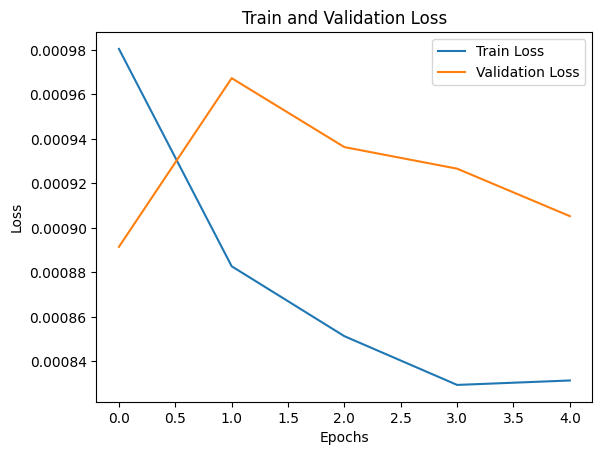

In [198]:
# Plotting training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [202]:
model_path = 'bhanucha_sethut_part3.pth'
torch.save(model.state_dict(), model_path)
print("Model saved successfully.")

Model saved successfully.


Hyperparameter Tuning

Changing - Number of Units: 64, 128

In [204]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3):
        super(SimpleRNN, self).__init__()
        self.rnn_layers = nn.ModuleList([
            nn.RNN(input_size if i == 0 else hidden_size, hidden_size, batch_first=True)
            for i in range(num_layers)
        ])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for rnn_layer in self.rnn_layers:
            x, _ = rnn_layer(x)
        x = self.fc(x[:, -1, :])
        return x

n_hidden = 64
model_1 = SimpleRNN(input_size=n_features, hidden_size=n_hidden, output_size=n_output)
print(model_1)

SimpleRNN(
  (rnn_layers): ModuleList(
    (0): RNN(1, 64, batch_first=True)
    (1-2): 2 x RNN(64, 64, batch_first=True)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [205]:
optimizer = optim.Adam(model_1.parameters(), lr=0.001)
train_losses, valid_losses = train_model(model_1, train_loader, val_loader, optimizer, criterion, num_epochs=5)

Epoch 1/5 took 173.34 seconds. Train Loss: 0.0072, Validation Loss: 0.0027
Epoch 2/5 took 170.79 seconds. Train Loss: 0.0034, Validation Loss: 0.0042
Epoch 3/5 took 134.87 seconds. Train Loss: 0.0022, Validation Loss: 0.0009
Epoch 4/5 took 131.37 seconds. Train Loss: 0.0028, Validation Loss: 0.0017
Epoch 5/5 took 131.47 seconds. Train Loss: 0.0025, Validation Loss: 0.0020


In [206]:
test_loss = evaluate_model(model_1, test_loader, criterion)

In [207]:
print(f'MSE Test Loss - Changing Number of Units: 64: {test_loss}')

MSE Test Loss - Changing Number of Units: 64: 0.00573567791700259


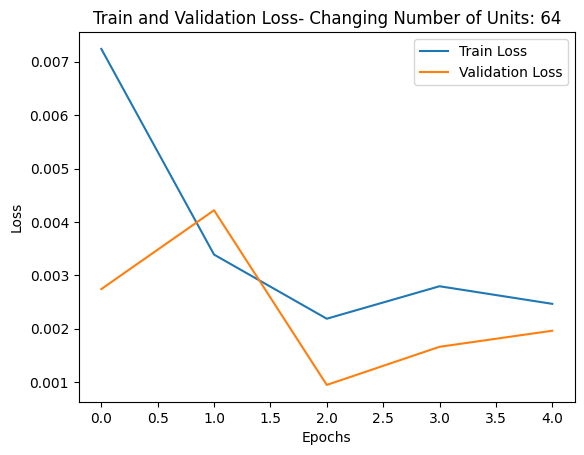

In [208]:
# Plotting training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss- Changing Number of Units: 64')
plt.legend()
plt.show()

In [209]:
n_hidden = 128
model_2 = SimpleRNN(input_size=n_features, hidden_size=n_hidden, output_size=n_output)
print(model_2)

SimpleRNN(
  (rnn_layers): ModuleList(
    (0): RNN(1, 128, batch_first=True)
    (1-2): 2 x RNN(128, 128, batch_first=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [210]:
optimizer = optim.Adam(model_2.parameters(), lr=0.001)
train_losses, valid_losses = train_model(model_2, train_loader, val_loader, optimizer, criterion, num_epochs=5)

Epoch 1/5 took 165.89 seconds. Train Loss: 0.0253, Validation Loss: 0.0153
Epoch 2/5 took 158.05 seconds. Train Loss: 0.0217, Validation Loss: 0.0151
Epoch 3/5 took 237.72 seconds. Train Loss: 0.0223, Validation Loss: 0.0156
Epoch 4/5 took 248.30 seconds. Train Loss: 0.0223, Validation Loss: 0.0158
Epoch 5/5 took 241.48 seconds. Train Loss: 0.0222, Validation Loss: 0.0158


In [211]:
test_loss = evaluate_model(model_2, test_loader, criterion)

In [212]:
print(f'MSE Test Loss - Changing Number of Units: 128: {test_loss}')

MSE Test Loss - Changing Number of Units: 128: 0.04016617272627544


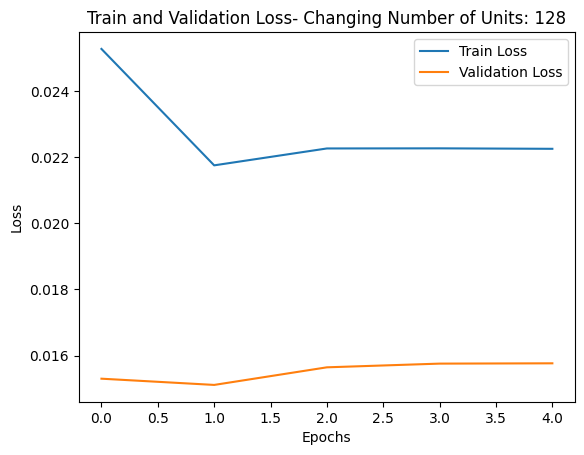

In [213]:
# Plotting training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss- Changing Number of Units: 128')
plt.legend()
plt.show()

Best for Units: 

Changing - Optimizer: SGD, RMSProp

In [214]:
n_hidden = 32 #our base model had better result in losss
model_3 = SimpleRNN(input_size=n_features, hidden_size=n_hidden, output_size=n_output)
print(model_3)

SimpleRNN(
  (rnn_layers): ModuleList(
    (0): RNN(1, 32, batch_first=True)
    (1-2): 2 x RNN(32, 32, batch_first=True)
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [215]:
optimizer_3 = optim.SGD(model_3.parameters(), lr=0.001)
train_losses, valid_losses = train_model(model_3, train_loader, val_loader, optimizer_3, criterion, num_epochs=5)

Epoch 1/5 took 124.11 seconds. Train Loss: 0.0180, Validation Loss: 0.0171
Epoch 2/5 took 97.57 seconds. Train Loss: 0.0115, Validation Loss: 0.0044
Epoch 3/5 took 98.48 seconds. Train Loss: 0.0031, Validation Loss: 0.0012
Epoch 4/5 took 98.89 seconds. Train Loss: 0.0022, Validation Loss: 0.0012
Epoch 5/5 took 98.29 seconds. Train Loss: 0.0021, Validation Loss: 0.0011


In [216]:
test_loss = evaluate_model(model_3, test_loader, criterion)

In [217]:
print(f'MSE Test Loss - Changing Optimizer: SGD : {test_loss}')

MSE Test Loss - Changing Optimizer: SGD : 0.003356179247648013


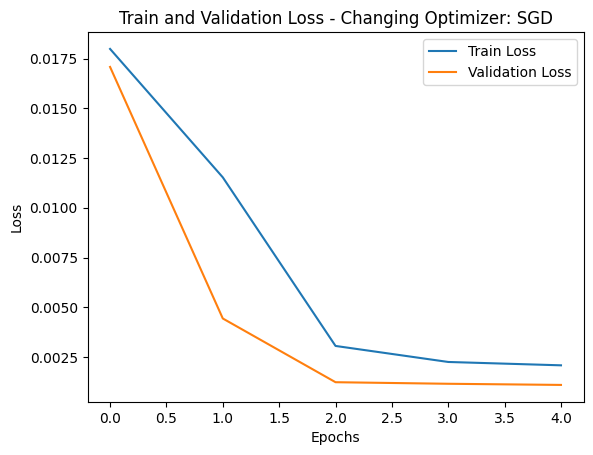

In [218]:
# Plotting training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss - Changing Optimizer: SGD')
plt.legend()
plt.show()

In [219]:
n_hidden = 32 #our base model had better result in losss
model_4 = SimpleRNN(input_size=n_features, hidden_size=n_hidden, output_size=n_output)
print(model_4)

SimpleRNN(
  (rnn_layers): ModuleList(
    (0): RNN(1, 32, batch_first=True)
    (1-2): 2 x RNN(32, 32, batch_first=True)
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [220]:
optimizer_4 = optim.RMSprop(model_4.parameters(), lr=0.001)
train_losses, valid_losses = train_model(model_4, train_loader, val_loader, optimizer_4, criterion, num_epochs=5)

Epoch 1/5 took 110.10 seconds. Train Loss: 0.0014, Validation Loss: 0.0010
Epoch 2/5 took 103.40 seconds. Train Loss: 0.0009, Validation Loss: 0.0017
Epoch 3/5 took 104.05 seconds. Train Loss: 0.0009, Validation Loss: 0.0009
Epoch 4/5 took 106.55 seconds. Train Loss: 0.0008, Validation Loss: 0.0010
Epoch 5/5 took 105.31 seconds. Train Loss: 0.0008, Validation Loss: 0.0011


In [221]:
test_loss = evaluate_model(model_4, test_loader, criterion)

In [222]:
print(f'MSE Test Loss - Changing Optimizer: RMSProp : {test_loss}')

MSE Test Loss - Changing Optimizer: RMSProp : 0.007706820474699411


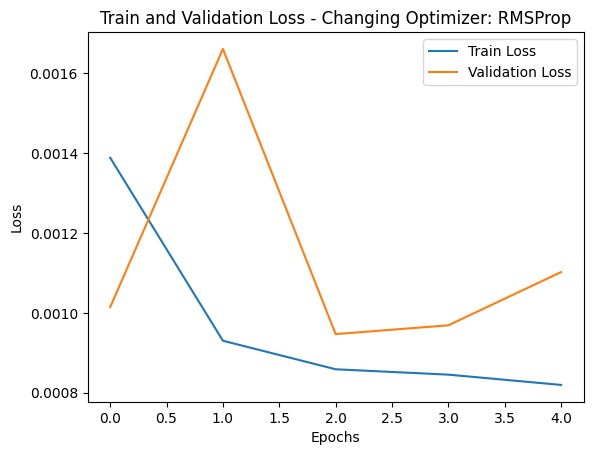

In [223]:
# Plotting training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss - Changing Optimizer: RMSProp')
plt.legend()
plt.show()